# Car price predictions using Machine Learning
## Introduction
The aim of this project is to implement an end-to-end machine learning system, including both the pre-processing  and model building process. The underlying regression problem asks for predicting car prices based on several features using machine learning methods. The project is based on the [US used cars dataset](https://www.kaggle.com/datasets/ananaymital/us-used-cars-dataset), a 10GB data set available on Kaggle. 

The data matrix contains 66 dimensions - including one price column and 65 features which can be used as potential model covariates. As labelled data is available, modelling is based on supervised ML methods.    


In [1]:
# Dependencies
import numpy as np
import pandas as pd
from pandas.plotting import scatter_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LinearRegression 
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import Ridge
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.compose import make_column_selector
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler

# centering plots
from IPython.core.display import HTML
HTML("""
<style>
.output_png {
    display: table-cell;
    text-align: center;
    vertical-align: middle;
}
</style>
""")

Several utility functions are pre-defined and used later on in the script. This shall make the script more readable.

In [2]:
#-------------------UTILITY FUNCTIONS-------------------  


# deleting columns with more than 50% of NA values
# INPUT: DataFrame
# OUTPUT: DataFrame
def pre_selector(data_frame):
    cols_remove = []
    i = 0
    while i < len(data_frame.columns):
        if (data_frame.iloc[:,i].isna().sum() / len(data_frame)) > 0.5:
            cols_remove.append(data_frame.columns[i])
        i = i + 1
        
    data_frame = data_frame.drop(columns = cols_remove)
    del i
    print((len(cols_remove)+1),
          "columns removed (reason: NA > 50%)\n",
          "columns removed:\n", cols_remove)
    return data_frame

# deleting dublicate rows
# INPUT: DataFrame
# OUTPUT: DataFrame
def duplicate_remover(data_frame):
    original_n = len(data_frame)
    data_frame = data_frame.drop_duplicates()
    duplicates_removed = original_n - len(data_frame)
    print(duplicates_removed, "rows removed (reason: duplicates)")
    return data_frame


# transforming a sparse matrix into a Pandas Data frame and assigning index
# INPUT: DataFrame, Index to be assigned
# OUTPUT: DataFrame
def sparse_to_df(df, index):
    df = df.toarray()
    df = pd.DataFrame(df)
    df = df.set_index(index)
    return(df)




## Data
For this project, a data set of size of 500MB is used. As the PC this project runs on was unable to process the full 10GB data set due to a lack of performance, a subset version of one of the 1GB data sets available is used for processing and model fitting. Choosing the 'right' amount of data the system can handle was done as an iterative process, slowly increasing the number of instances used for processing. 

The code below loads the 1GB version and randomly samples 50% of the initial instances, resulting in approximately 500MB of data.

In [33]:
data = pd.read_csv(r'/Users/nicoherrig/Desktop/MSc Appld. Statistic/Knowledge Discovery and Data Mining/Assignment1/Data/used_cars_data_large_0.csv', low_memory=False)

samp_size = int(len(data)/2)

data = data.sample(n = samp_size, random_state = 911).reset_index(drop=True)


print('data matrix has the shape',data.shape[0],'*',data.shape[1],'and includes the following data types:\n',list(data.dtypes.unique()))

data matrix has the shape 147751 * 66 and includes the following data types:
 [dtype('O'), dtype('float64'), dtype('int64'), dtype('bool')]


### Pre-Cleaning and Data Overview
The pre-cleaning process ensures that we are not working with dimensions containing too few information or dublicated information. In detail, this step omitts dimensions which include more than 50% of NA values, as well as dublicated rows. Further, *year* is transformed into a string value to use it as a categorical variable later on.

In [5]:
########################### Pre-Cleaning  ########################################

data = duplicate_remover(data) # removing duplicate rows
data = pre_selector(data) # removing columns with more than 50% NA values
data['year'] = data['year'].astype('str')


0 rows removed (reason: duplicates)
10 columns removed (reason: NA > 50%)
 columns removed:
 ['bed', 'bed_height', 'bed_length', 'cabin', 'combine_fuel_economy', 'is_certified', 'is_cpo', 'is_oemcpo', 'vehicle_damage_category']


As dublicated instances  and columns with too many NA values are removed, we can now take an initial look at the data we are working with. 

In [6]:
data.head()

,vin,back_legroom,body_type,city,city_fuel_economy,daysonmarket,dealer_zip,description,engine_cylinders,engine_displacement,...,torque,transmission,transmission_display,trimId,trim_name,wheel_system,wheel_system_display,wheelbase,width,year
0,YV4BR0CKXM1671586,37 in,SUV / Crossover,Exeter,58.0,25,03833,Blue 2021 Volvo XC90 T8 Inscription AWD Hybrid...,I4,2000.0,...,"472 lb-ft @ 2,200 RPM",A,Automatic,t94012,Recharge Inscription Expression 7-Passenger eAWD,AWD,All-Wheel Drive,117.5 in,84.3 in,2021
1,5UXTY5C03M9D84664,NaN,SUV / Crossover,Stratham,NaN,25,03885,We are excited to offer this 2021 BMW X3. This...,NaN,NaN,...,NaN,A,Automatic,NaN,NaN,NaN,NaN,NaN,NaN,2021
2,4T1BE46K09U287481,38.3 in,Sedan,East Patchogue,21.0,22,11772,"[!@@Additional Info@@!]4 Cylinder Engine,4-Whe...",I4,2400.0,...,"161 lb-ft @ 4,000 RPM",A,Automatic,t33066,LE,FWD,Front-Wheel Drive,109.3 in,71.7 in,2009
3,JN8AT2MV7LW123958,37.9 in,SUV / Crossover,Milford,25.0,88,01757,"$3,642 off MSRP! 4-Piece Splash Guards $170 Re...",I4,2500.0,...,"175 lb-ft @ 4,400 RPM",CVT,Continuously Variable Transmission,t86700,SV AWD,AWD,All-Wheel Drive,106.5 in,72.4 in,2020
4,YV4SZ592171258058,35.2 in,SUV / Crossover,Hampden,16.0,4,01036,[!@@Additional Info@@!]Memorized Settings Incl...,I5,2500.0,...,"236 lb-ft @ 1,500 RPM",A,Automatic,t27081,2.5T AWD,AWD,All-Wheel Drive,108.8 in,73.2 in,2007


### Data Exploration
This chapter intends to give a first impression of the data. Particularly the relationship between different features and the dependen variable *price* is of interest.

In [7]:
round(data['price'].describe())

count     147751.0
mean       30240.0
std        20474.0
min          299.0
25%        18499.0
50%        27154.0
75%        38250.0
max      2698500.0
Name: price, dtype: float64

The distribution of 'price' shows a large right-skewness: While most of the values lie in a range below USD 40,000, there seem to be some outliers in the data set.

In [8]:
thresholds = [100000, 200000, 500000, 1000000]

for i in range(0, len(thresholds)): 
               print('cars which cost more than USD',thresholds[i],':',len(data[data['price']>thresholds[i]]))

cars which cost more than USD 100000 : 1043
cars which cost more than USD 200000 : 147
cars which cost more than USD 500000 : 4
cars which cost more than USD 1000000 : 1


We might take a look at certain car-specific features which effect the price of a car. One attribute which could be of interest is the car manufacturer (*make_name*).

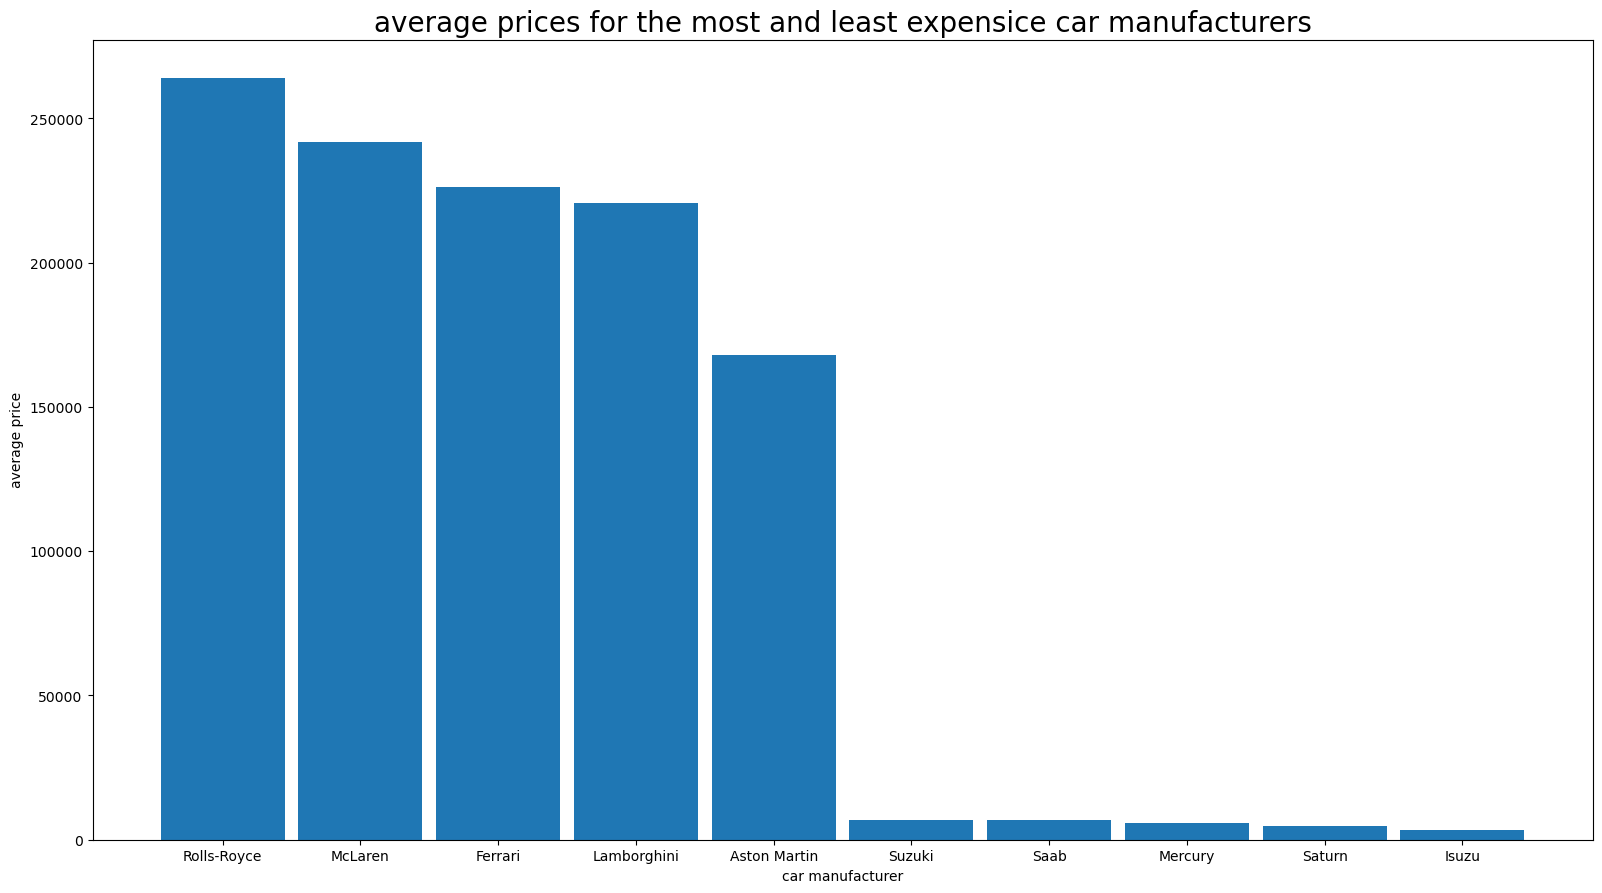

In [9]:
# plotting the most and least expensive car brands

brand_price = pd.DataFrame(data.groupby('make_name')['price'].mean())
brand_price = brand_price.reset_index()
# plotting the head and tail from the data frame including mean prices of car manufacturers
brand_price_plt = pd.concat([brand_price.sort_values('price', ascending=False).head(), brand_price.sort_values('price', ascending=False).tail()])

fig = plt.figure(figsize=(15, 8))
ax = fig.add_axes([0,0,1,1])
langs = brand_price_plt['make_name']
students = brand_price_plt['price']
ax.bar(langs,students, width = 0.9)
ax.set(xlabel="car manufacturer",
       ylabel="average price")
ax.set_title("average prices for the most and least expensice car manufacturers", fontsize=20)
plt.show()

The average price for a McLaren is almost 50 times the average price of a Saturn, indicating that the car brand strongly affects the car's price. 

Another interesting attribute could be the car type: We would expect that the average sports car (types like a coupe or a convertible) are more expensive than the average van.

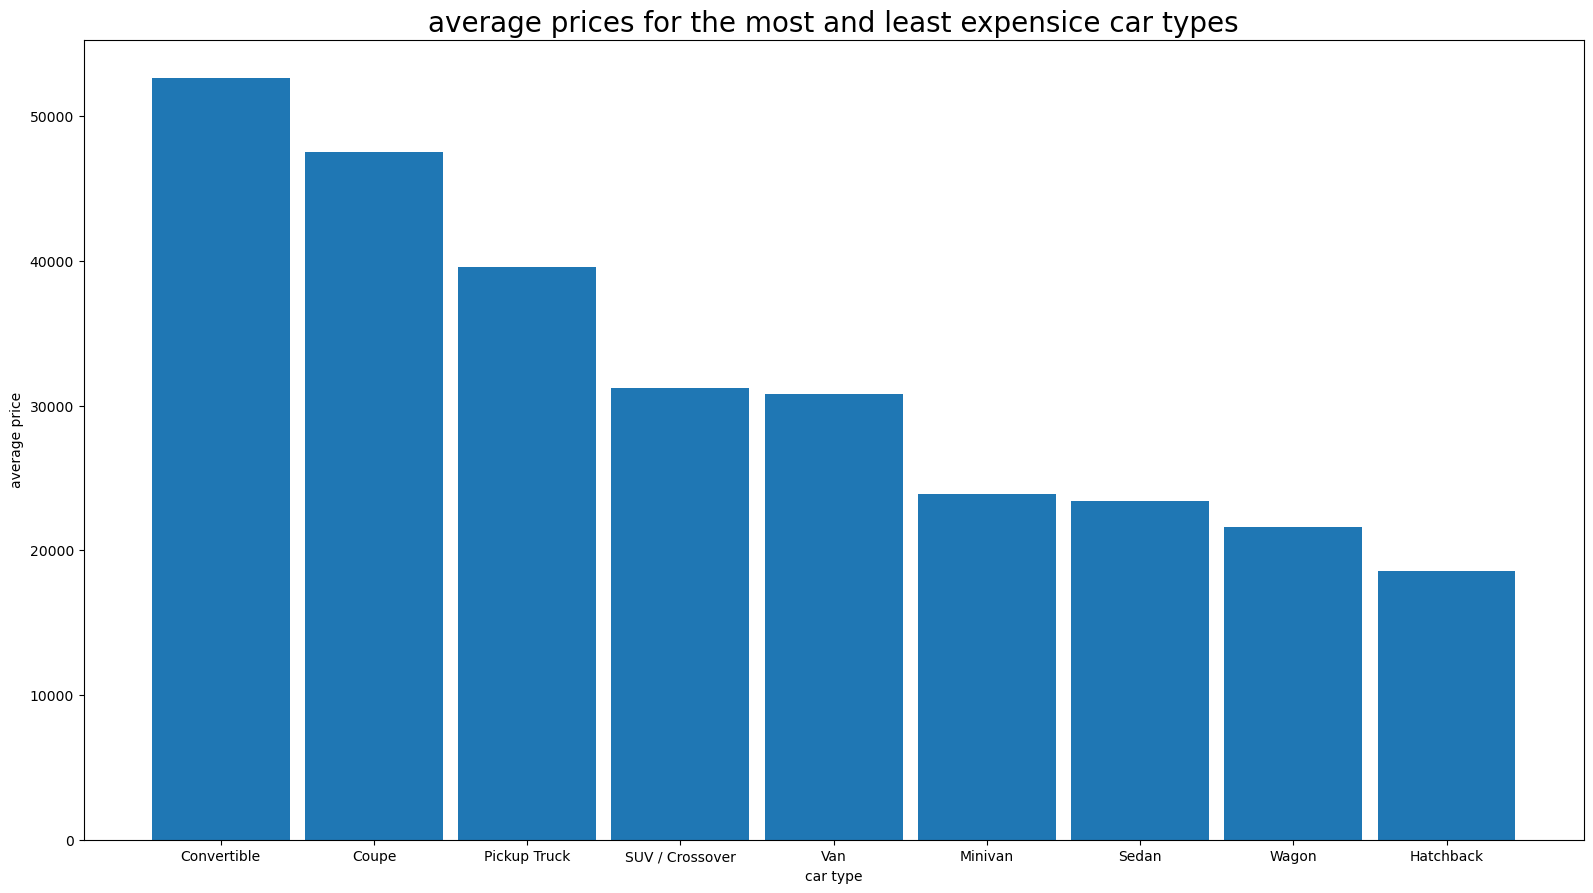

In [10]:
body_price = pd.DataFrame(data.groupby('body_type')['price'].mean())
body_price = body_price.reset_index()
body_price_plt = pd.concat([body_price.sort_values('price', ascending=False).head(), body_price.sort_values('price', ascending=False).tail()])

fig = plt.figure(figsize=(15, 8))
ax = fig.add_axes([0,0,1,1])
x = body_price_plt['body_type']
y = body_price_plt['price']
ax.bar(x,y, width = 0.9)
ax.set(xlabel="car type",
       ylabel="average price")
ax.set_title("average prices for the most and least expensice car types", fontsize=20)
plt.show()

The plots show that both the car manufacturer as well as the car type are affecting a car's price. It can be expected that car-specific attributes have a strong relation with *price* and therefore might be included in the model.

In [11]:
# deleting data frames due to memory usage
del [brand_price, brand_price_plt, body_price, body_price_plt]

Further, it might be of interest to see if car prices vary by region. As the data set contains geographical information (*longitude* and *latitiude* and *city*), we should look for a potential relation.

The following plot visualises the geographical relationship between geographical data and the price. As the price includes severe outliers and its distribtion is heavily right-skewed, *price* is plotted on a log scale. 

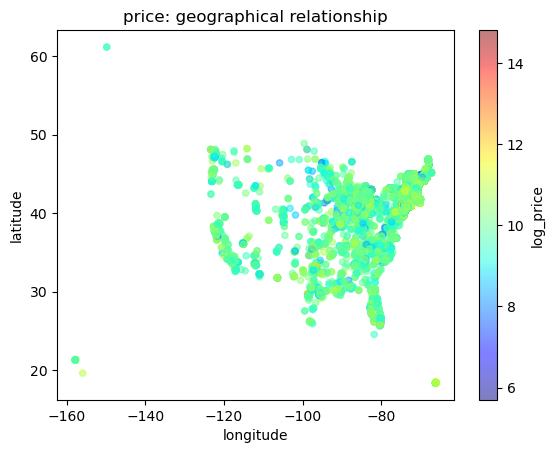

In [12]:
data['log_price'] = np.log(data['price']) # geo scatterplot
data.plot(kind = "scatter",
                  x = 'longitude',
                  y = 'latitude',
                  alpha = 0.5,
                  c = 'log_price', cmap = plt.get_cmap("jet")).set(title = "price: geographical relationship")

data = data.drop(columns = 'log_price', axis=1) #removing log-price 

The geographical plot above does not show any patterns for a potential relationship between the region a car is sold and its price, leading to the conclusion that the *longitude* and *latitiude* variables might not be related to the dependend variable. The correlation analysis in the next chapter will give further insights.

## Feature Selection
Feature selection is performed as an iterative process and is reassessed several times based on model results. Generally, we are interested in attributes which are strongly correlated with 'price'. 

In [13]:
corr_mat = data.select_dtypes(include = np.number).corr()
corr_ranks_price = corr_mat["price"].sort_values(ascending=False)
display(corr_ranks_price)


price                   1.000000
horsepower              0.575775
engine_displacement     0.303372
daysonmarket            0.097333
seller_rating           0.061686
longitude               0.039972
latitude               -0.002981
savings_amount         -0.003932
listing_id             -0.092459
sp_id                  -0.143576
city_fuel_economy      -0.150466
owner_count            -0.216000
highway_fuel_economy   -0.218056
mileage                -0.447246
Name: price, dtype: float64

Engine displacement, horsepower and milage have a moderate to strong correlation with the dependent variable.

<AxesSubplot:>

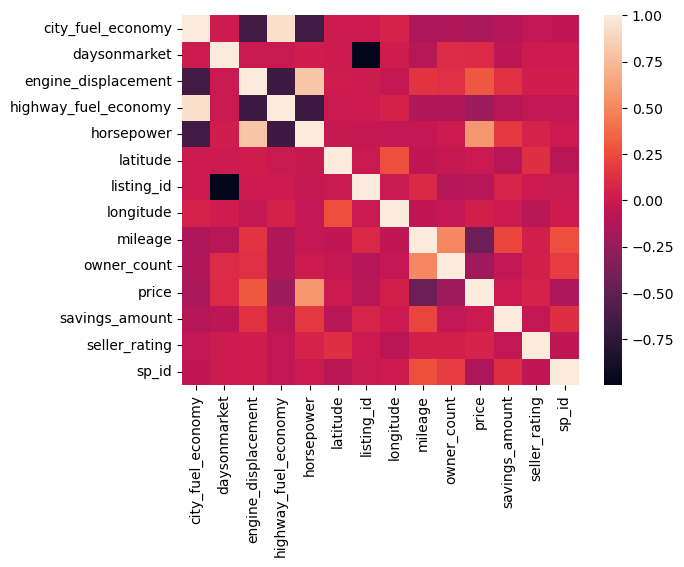

In [14]:
sns.heatmap(corr_mat)

**Numerical Features**

The correlation coefficients from above give us a brief idea on which attributes might be of interest for the ML model. As a basic threshold, attributes with a correlation coefficient between 0.3 and -0.3 are omitted from the list of numerical features in a first step. However, (pearson) correlation coefficients soely measure the linear relationship between two variables and are not the only decidable factor for numerical feature selection. In example, *seller_rating* was added to the final list of numerical attributes as it turned out to be one of the most important features for the Random Forest regressor (measured by mean decrease impurity).

In [15]:
# dropping attributes which have a correlation < 0.3 with price.
numerical_attrb = list(corr_ranks_price[np.absolute(corr_ranks_price) > 0.3].index)
numerical_attrb.append('seller_rating') # adding seller_rating to the model

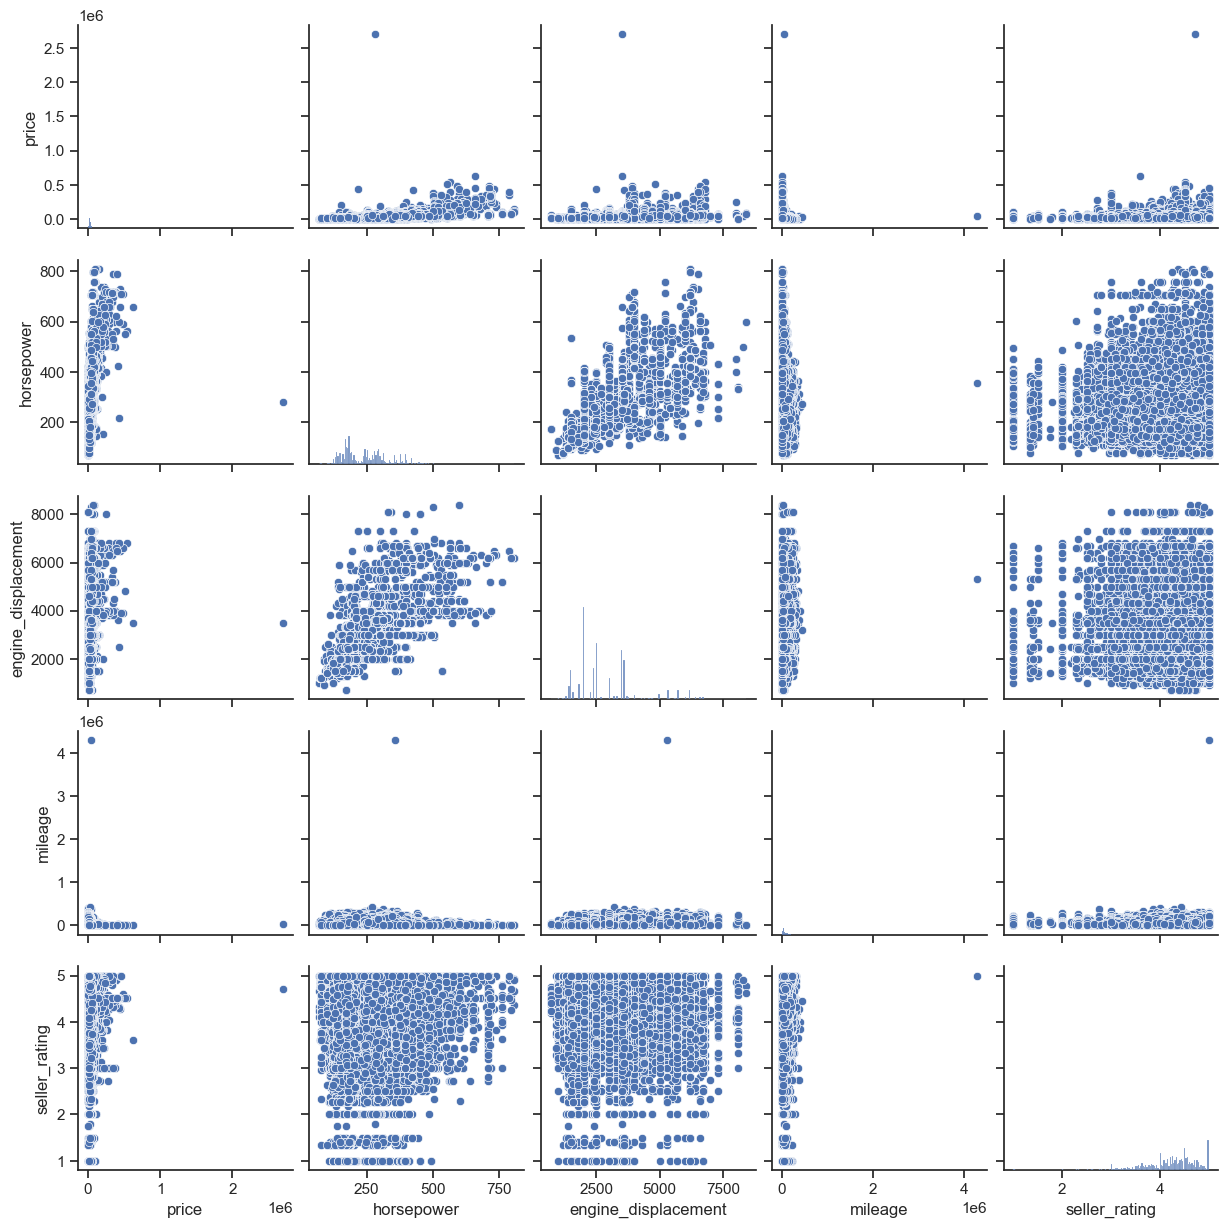

In [16]:
import seaborn as sns

# correlation scatterplot
sns.set_theme(style="ticks") 
sns.pairplot(data[numerical_attrb])

The scatterplots support the correlation results from above. We can see distinct patterns in the highly correlared variables.

In [17]:
round(data[numerical_attrb].describe(),2)

,price,horsepower,engine_displacement,mileage,seller_rating
count,147751.00,140016.0,140016.00,141719.00,145766.00
mean,30240.06,244.9,2866.50,30897.70,4.21
std,20473.83,87.2,1242.12,44393.47,0.56
min,299.00,70.0,700.00,0.00,1.00
25%,18499.00,175.0,2000.00,7.00,3.92
50%,27154.00,241.0,2500.00,12978.00,4.31
75%,38250.00,295.0,3500.00,43762.00,4.58
max,2698500.00,808.0,8400.00,4290461.00,5.00


In [18]:
# categorical attributes
categorical_attrb = ['body_type', 
                     'engine_type',
                     'fuel_type',
                     'listing_color',
                     'make_name',
                     'maximum_seating',
                     'transmission',
                     'wheel_system',
                     'major_options',
                     'year']


# measurements: attributes which which will be transformed into numeric values during pre-processing
measurements = ['back_legroom',
                'width',
                'height',
                'front_legroom',
                'fuel_tank_volume',
                'wheelbase']

# attributes to keep
attributes_keep = numerical_attrb + categorical_attrb + measurements 

# duplicating data into working data frame
# 'data' is pre-cleaned and unfiltered data frame 
working_data = data[attributes_keep].copy() 

Besides the numerical variables, we want to include such categorical features which give the most information about the car and are affecting the price. We are looking for attributes which would lead to an increase/decrease given all other attributes stay the same, e.g. further options in a car like bluethooth connection or heads-up display, or a larger engine. Further, we want to avoid highly cardinality in one of the model attributes as our data matrix would get highly dimensional due to the later variable transformation using One Hot encoding. 

The attributes we keep are either giving car-specific information (manufacturer, horsepower, wheel_system etc.) or information about the car condition (year, mileage, seller rating). 

In [19]:
print(attributes_keep)

['price', 'horsepower', 'engine_displacement', 'mileage', 'seller_rating', 'body_type', 'engine_type', 'fuel_type', 'listing_color', 'make_name', 'maximum_seating', 'transmission', 'wheel_system', 'major_options', 'year', 'back_legroom', 'width', 'height', 'front_legroom', 'fuel_tank_volume', 'wheelbase']


## Data Split
The next step in our process is to split the data into a train set and a test set with a ratio of 80/20. As  the price data is highly skewed, it needs to be ensured that both the train set and the test set include a certain amount of instances from every price range. Therefore, a categorical price variable *price_cat* is included in the data set, labeling the observations by price range. We want to ensure that the training set and the test set are both getting the same proportions of cars from the four defined price ranges (0-29,999; 30,000 - 59,999; 60,000 - 89,999, 90,000+).  

In [20]:
working_data['price_cat'] = [np.nan for i in range(len(data.index))]
working_data.loc[working_data['price'] < 30000, 'price_cat'] = 1 # assigning price_cat labels based on binning
working_data.loc[working_data['price'] >= 30000, 'price_cat'] = 2
working_data.loc[working_data['price'] >= 60000, 'price_cat'] = 3
working_data.loc[working_data['price'] >= 90000, 'price_cat'] = 4
working_data['price_cat'].value_counts() / len(working_data)

1.0    0.587719
2.0    0.364816
3.0    0.037584
4.0    0.009881
Name: price_cat, dtype: float64

Based on the created price labels, the **sklearn StratifiedShuffleSplit** function is used for stratified sampling. Afterwards, *price_cat* gets deleted from the data frame. 

In [21]:
# Train-test split

# stratified sampling
split = StratifiedShuffleSplit(n_splits = 1, test_size = 0.2, random_state = 123)
for train_index, test_index in split.split(working_data, working_data['price_cat']):
    train_strat = working_data.loc[train_index] 
    test_strat = working_data.loc[test_index]



strat_categories = pd.DataFrame({'proportions full data set': working_data['price_cat'].value_counts(sort=False)/len(working_data),
                                 'proportions stratified train set':train_strat['price_cat'].value_counts(sort=False)/len(train_strat),
                                 'difference': (train_strat['price_cat'].value_counts(sort=False)/len(train_strat)) - (working_data['price_cat'].value_counts(sort=False)/len(working_data))})

# dropping categorical price labels
train_strat = train_strat.drop(columns = ['price_cat'], axis=1)
test_strat = test_strat.drop(columns = ['price_cat'], axis=1)

train_strat_raw = train_strat.copy() # saving uncleaned copy of train set

display(strat_categories)

,proportions full data set,proportions stratified train set,difference
1.0,0.587719,0.587716,-2.790399e-06
2.0,0.364816,0.364814,-2.606995e-06
3.0,0.037584,0.037589,5.330514e-06
4.0,0.009881,0.009882,6.687980e-08


The table above shows that the stratified sampling was successfull, as the same proportions of each bin are included in the train and test set.

## Pre-Processing
As a next step we set up a data processing pipeline to transform the data into the format we want to work with for model fitting. The pieline includes two major steps: pre-wrangling and transformation. 

The first step (*wrangling*)transforms *major_options* (the optinal car features included in the car, e.g., Bluetooth or heated seating) from a descriptive variabe in string format into a numerical count of features included (*major_options_sum*). Further, it removes measurement abreviations from certain variables and transforms them into float type.

The second step (*transformation*) is further split up into processing numerical and categorical features. Missing numerical features are first replaced by the median and then scaled  according to the interquantile range (IQR) using **sklearn.RobustScaler**, a method which is more robust to outliers then e.g., min-max scaling. The categorical transformation first replaces missing values with the most frequent value of the attribute and then transforms the categorical data to binary using **sklearn.OneHotEncoder**.

In [22]:
## Pre-Processing##



############# Custom Transformers ##############################################
# custom transformers for data wrangling, which will be included in Pipeline "wrangler"

# string_to_count: transforms object major_options into numerical count value by counting numer of major options implemented
# in the car
class string_to_count(BaseEstimator, TransformerMixin):
    
    def fit(self, X, y = None):
        return(self)
    
    def transform(self, X):
        X['major_options_sum'] = X['major_options'].str.count(',')+1
        X = X.drop(columns = ['major_options'], axis = 1)
        return(X)


# unit_remover: removes unit abreviations from attributes contained in the list 'measurements' and transforms
# them into floats
class unit_remover(BaseEstimator, TransformerMixin):
    
    def fit(self, X, y = None):
        return(self)
    
    def transform(self,X):
        for i in range(0, len(measurements)):
            X[measurements[i]]= X[measurements[i]].str.replace("in","")
            X[measurements[i]]= X[measurements[i]].str.replace("gal","")
            X[measurements[i]]= X[measurements[i]].str.replace("--","NaN")
            X[measurements[i]]= X[measurements[i]].astype('float')
        return(X)

        
# separating labels 'price' from data set
Y_train = train_strat['price'].copy() # storing labels in Y_train variable
train_strat = train_strat.drop(columns = ['price'], axis = 1) # dropping price
train_strat_raw = train_strat_raw.drop(columns = ['price']) #same with raw copy


############# DATA WRANGLER ##############################################
wrangler = Pipeline([
    ('string_to_count', string_to_count()),
    ('unit_remover', unit_remover())
])

############# NUMERICAL PIPELINE ##############################################
print("NA in numerical features (pre-imputation)in %:""\n", (train_strat.select_dtypes(include=np.number).isna().sum()/ len(train_strat)))


num_pipeline = Pipeline([ # working
    ('median_imputer', SimpleImputer(strategy = "median")),
    ('std_scaler', RobustScaler())
])


############# CATEGORICAL PIPELINE #############################################
print("NA in categorical features (pre-imputation) in %:""\n", (train_strat.select_dtypes(exclude=np.number).isna().sum()/ len(train_strat)))
cat_pipeline = Pipeline([
    ('mode_imputer', SimpleImputer(strategy = 'most_frequent')),
    ('OHE', OneHotEncoder(handle_unknown='ignore'))])

######################### FULL TRANSFORMER #######################################
 
full_transformer = ColumnTransformer([
    ("num", num_pipeline, make_column_selector(dtype_include = np.number)),
    ("cat", cat_pipeline, make_column_selector(dtype_exclude = np.number))]) 

######################### FINAL DATA PIPELINE #######################################

data_pipeline = Pipeline(steps = [
    ('wrangling', wrangler),
    ('transformation', full_transformer)
])



NA in numerical features (pre-imputation)in %:
 horsepower             0.052479
engine_displacement    0.052479
mileage                0.040863
seller_rating          0.013291
dtype: float64
NA in categorical features (pre-imputation) in %:
 body_type           0.004255
engine_type         0.030195
fuel_type           0.024729
listing_color       0.000000
make_name           0.000000
maximum_seating     0.048773
transmission        0.014332
wheel_system        0.045152
major_options       0.075821
year                0.000000
back_legroom        0.048773
width               0.048773
height              0.048773
front_legroom       0.048773
fuel_tank_volume    0.048773
wheelbase           0.048773
dtype: float64


We are now fitting the pipeline (i.e., its transformation part) to the training data and transforming it into the input matrix for model training. As the pipeline returns a sparse matrix, the corresponding utility function is used to transfom the sparse matrix into a **pandas.DataFrame**.

In [23]:
# generating input matrix for model fitting
X_train = data_pipeline.fit_transform(train_strat)
X_plot = X_train.copy() # for later plotting

X_train = sparse_to_df(X_train, index = train_strat.index)
X_plot = sparse_to_df(X_plot, index = train_strat.index)

display(X_train.head())

,0,1,2,3,4,5,6,7,8,9,...,221,222,223,224,225,226,227,228,229,230
129087,-0.865546,-0.600000,2.714867,-1.710711,0.290323,-0.79,-0.247706,0.105263,-0.921569,-1.122222,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
139820,-0.747899,-0.333333,-0.306320,0.300879,-0.516129,-0.72,-0.229358,0.631579,-0.156863,-0.622222,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
119957,-0.789916,-0.333333,0.568697,-1.176163,-0.774194,-0.73,-0.880734,0.157895,-0.666667,-0.466667,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
142263,0.369748,0.733333,-0.306297,0.331826,0.064516,-0.44,0.917431,-0.368421,0.901961,2.977778,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
45769,-0.495798,0.000000,0.319446,-2.093871,-0.645161,-0.62,-0.743119,1.631579,0.117647,-0.133333,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0


## Model Fitting and Hyperparameter Tuning
The generated imput matrix is now used for model fitting and parameter tuning. The chosen model types are:
- K-Nearest Neighbors Regression
- Random Forest Regression
- Ridge Regression

All of these models have their advantages over each other, which are explained in the following. The root-mean-square-error (RMSE) is used as a performance measurement. RMSE is defined as following: $\sqrt{(\frac{1}{n})\sum_{i=1}^{n}(\bar{y_{i}} - y_{i})^{2}}$


From this equation can be derived that RMSE measures the average difference between values predicted by a model and the actual values. What makes RMSE so useful is that it is on the same scale than the dependent variable (*price* in this case) and therefore is easily interpretable.

### K-Neares Neighbors Regression
The k-nearest neighbors regression is the regression-counterpart of the kNN classification algorithm. Similar to the kNN classifier, kNN regression calculates its predictions by analysing the dependent features from the k-nearest observations (measured by the euclidean distance) and calculates the average of the dependent variable from those. What makes this regressor interesting for the underlying problem is that it is a non-parametric algorithm, meaning it is not based on a specific probability distribution (in contrast to, e.g., the linear regression which is based on the assumption of a normally distributed error term). As the error distribution of the data is unknown, this property could give an advantage compared to parametric models.\
As the number of neighbors to analyse (*k*) is the crucial parameter for kNN, this is the parameter we are going to optimize using a grid search approach.

In [24]:
############################# 1. kNN Regression ############################

#defining kNN Regressor
kNN_reg = KNeighborsRegressor(n_neighbors = 5)

# k-grid for grid search
kNN_grid = {'n_neighbors': [3,5,7]}

# defining object grid search
grid_search_kNN = GridSearchCV(kNN_reg,
                              kNN_grid,
                              cv=3, # "just" 3-fold CV due to run time issues
                              scoring='neg_mean_squared_error',
                              return_train_score=True)

# gird search for evaluation best parameters (here: k)
grid_search_kNN.fit(X_train, Y_train)


# optimal parameters
kNN_best_parameters = grid_search_kNN.best_params_
print("best k-value for kNN Regressor:\n",kNN_best_parameters)

# implementing kNN Regressor with optimal parameters
kNN_reg = grid_search_kNN.best_estimator_

# fitting on train data
kNN_reg.fit(X_train, Y_train)

# evaluation via 5-fold cross validation, using RMSE as metric
kNN_reg_scores = cross_val_score(kNN_reg,
                                 X_train,
                                 Y_train,
                                 scoring = "neg_mean_squared_error",
                                 cv=5)

kNN_reg_RMSE = np.sqrt(-kNN_reg_scores)
model_scores_kNN = pd.DataFrame({'kNN Regression (RMSE)': [int(kNN_reg_RMSE.min().round()),
                                                          int(kNN_reg_RMSE.max().round()),
                                                          int(kNN_reg_RMSE.mean().round()),
                                                          int(kNN_reg_RMSE.std().round())]},
                            index = ['min', 'max','mean', 'std dev'])

print('kNN Regressor average RMSE:', round(kNN_reg_RMSE.mean()))

best k-value for kNN Regressor:
 {'n_neighbors': 7}
kNN Regressor average RMSE: 9752


### Random Forest Regression
Random Forest regression combines the idea of decision trees with sample bootstrapping and ensemble learning. In detail, the algorithm fits several decision trees dealing with different predictors using bootstrapped samples. The different results at the end of each node are then averaged, which often produces a more accurate result then basic decision trees.\
As Random Forest algorithms are computational intensive, we focus solely on a certain selection of parameters for optimization, which are the numer of fitted trees (*n_estimators*), the maximum number of features per tree (*max_features*) and the maximum depth a tree can 'grow to' until it reaches the leaf node.

In [25]:
############################# 2. Random Forest Regression ######################
# fitting Random Forest Regression
RF_reg = RandomForestRegressor()


# defining values for grid 
n_estimators = [30, 50, 100]
max_features = ['auto', 'log2']
max_depth = [5, 7, None]
bootstrap = [True]

# generating grid for GridSearch
rf_grid = {'n_estimators':n_estimators,
              'max_features':max_features,
              'max_depth': max_depth,
              'bootstrap': bootstrap,
              'criterion': ['squared_error'],
              'random_state': [911]}


grid_search_rf = GridSearchCV(RF_reg,
                              rf_grid,
                              cv=3, 
                              scoring='neg_mean_squared_error',
                              return_train_score=True)


grid_search_rf.fit(X_train, Y_train)


# optimal parameters
rf_best_parameters = grid_search_rf.best_params_
print("best parameters for Random Forest Regressor:\n",rf_best_parameters)

# Random Forest Regressor with best parameters
RF_reg = grid_search_rf.best_estimator_

# fitting RF model
RF_reg.fit(X_train, Y_train)
RF_reg_scores = cross_val_score(RF_reg,
                                 X_train,
                                 Y_train,
                                 scoring = "neg_mean_squared_error",
                                 cv=5)

RF_reg_RMSE = np.sqrt(-RF_reg_scores) 

model_scores_RF = pd.DataFrame({'Random Forest Regression (RMSE)': [int(RF_reg_RMSE.min().round()),
                                                          int(RF_reg_RMSE.max().round()),
                                                          int(RF_reg_RMSE.mean().round()),
                                                          int(RF_reg_RMSE.std().round())]},
                            index = ['min', 'max','mean', 'std dev'])

print('Randon Forest Regressor average RMSE:', round(RF_reg_RMSE.mean()))

best parameters for Random Forest Regressor:
 {'bootstrap': True, 'criterion': 'squared_error', 'max_depth': None, 'max_features': 'auto', 'n_estimators': 100, 'random_state': 911}
Randon Forest Regressor average RMSE: 8683


### Ridge Regression
The Ridge regression is a type of penalized regression method which penalizes model covariates with comparably large coefficients. The penalty term is based on the euclidean norm (L2-norm) and the model is not fitted on OLS but on a ridge estimator. Due to these properties, Ridge regression has the advantage that it handles multicollinearity better than e.g., a linear regression model.\
The lambda parameter (here denoted as alpha) is regulating the penalty strength and therefore the bias-variance trade-off. As lambda increases, the model trades a bigger portion of bias (increasing) agains a decrease in variance. 

In [26]:
############################# 3. Ridge Regression ######################
 

ridge_reg = Ridge()
alpha_grid = {'alpha': np.logspace(-5,2,8)}

grid_search_ridge = GridSearchCV(ridge_reg,
                                 alpha_grid,
                                 cv=3, 
                                 scoring='neg_mean_squared_error',
                                 return_train_score=True)


grid_search_ridge.fit(X_train, Y_train)


ridge_grid_results = pd.DataFrame({'Ridge Regresion (RMSE)': np.sqrt(-(grid_search_ridge.cv_results_["mean_test_score"])),
             'parameter combination': grid_search_ridge.cv_results_["params"]})

ride_best_alpha = grid_search_ridge.best_params_
print("best alpha parameter for Ridge Regression:\n",grid_search_ridge.best_params_)

ridge_reg = grid_search_ridge.best_estimator_ #(alpha = 1 is default parameter)
ridge_reg.fit(X_train, Y_train)

ridge_reg_scores = cross_val_score(ridge_reg,
                                 X_train,
                                 Y_train,
                                 scoring = "neg_mean_squared_error",
                                 cv=5)


ridge_reg_RMSE = np.sqrt(-ridge_reg_scores) 

model_scores_ridge = pd.DataFrame({'Ridge Regression (RMSE)': [int(ridge_reg_RMSE.min().round()),
                                                          int(ridge_reg_RMSE.max().round()),
                                                          int(ridge_reg_RMSE.mean().round()),
                                                          int(ridge_reg_RMSE.std().round())]},
                            index = ['min', 'max','mean', 'std dev'])

print('Ridge Regressor average RMSE:', round(ridge_reg_RMSE.mean()))

best alpha parameter for Ridge Regression:
 {'alpha': 1.0}
Ridge Regressor average RMSE: 11198


## Model Evaluation
The following chapter deals with evaluating the fitted models using their optimal parameters. Because the underlying problem is classified as a regression problem dealing with a continuous dependent variable, we will compare the average root-mean-square-errors of the models. 

In [27]:
table_cv_scores_summary = pd.concat([model_scores_kNN,
                                     model_scores_RF,
                                     model_scores_ridge],
                                    axis = 1)
display(table_cv_scores_summary)

,kNN Regression (RMSE),Random Forest Regression (RMSE),Ridge Regression (RMSE)
min,6734,5855,8469
max,18459,17999,19506
mean,9752,8683,11198
std dev,4411,4676,4182


The Random Forest Regression performs best on average, with an average RMSE of 8683. However, all models tend to have a large variance in their cv-scores. Due to its overall performance, we will pick the Random Forest regressor as our final model we want to implement.

[Text(0.5, 1.0, 'Comparison: CV Score')]

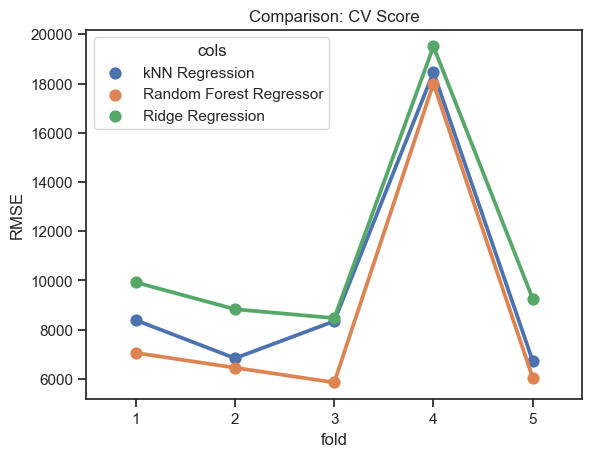

In [28]:
# plot of CV scores
table_cv_scores_eachfold = pd.DataFrame({'fold' : [1,2,3,4,5],
                                        'kNN Regression': kNN_reg_RMSE,
                                        'Random Forest Regressor': RF_reg_RMSE,
                                        'Ridge Regression': ridge_reg_RMSE})

table_cv_scores_eachfold_long = table_cv_scores_eachfold.melt('fold', var_name='cols', value_name='RMSE')
sns.pointplot(x='fold', y='RMSE', hue='cols', data=table_cv_scores_eachfold_long).set(title='Comparison: CV Score')

The plot above shows that the variance is mainly due to a peak in RMSE scores at fold 4, which can be observed for all models. The peak indicates that models might suffer from variance - which is explained later on in the conclusion part.

[Text(0.5, 1.0, 'Random Forest Reg.: top 20 most important features')]

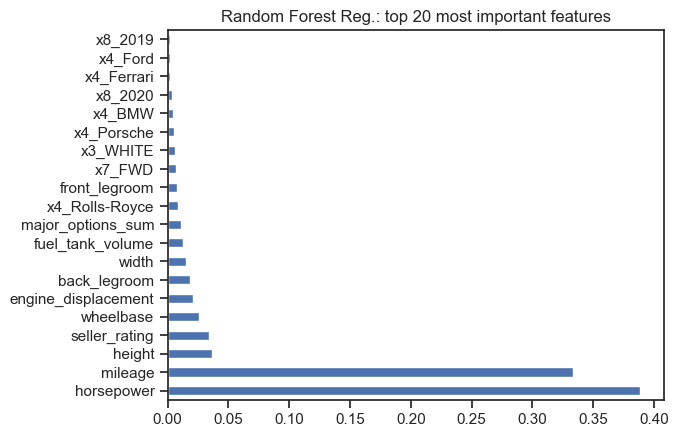

In [29]:
# plotting Random Forst feature importance based on Gini index.
# adding column names 
OHE_columns = list(data_pipeline.named_steps['transformation']\
                      .named_transformers_["cat"]\
                      .named_steps["OHE"]\
                      .get_feature_names_out())

numerical_columns = list(wrangler.transform(train_strat).select_dtypes(include=np.number).columns)
attributes =  numerical_columns + OHE_columns 
X_train.columns = attributes


feat_importances = pd.Series(RF_reg.feature_importances_, index=X_train.columns)
feat_importances.nlargest(20).plot(kind='barh').set(title = "Random Forest Reg.: top 20 most important features")

The horsepower and mileage of a car are the dominat features in the regression model, contributing the most to the model's predictive power. Futher, we can see that other numerical car-specific features like car measurements (height, wheelbase and width) are of importance as well as the car manufacturer (*x4*). This confirms our initial expectation from the exploratory analysis. 

Text(0.06, 0.5, 'RMSE (mean)')

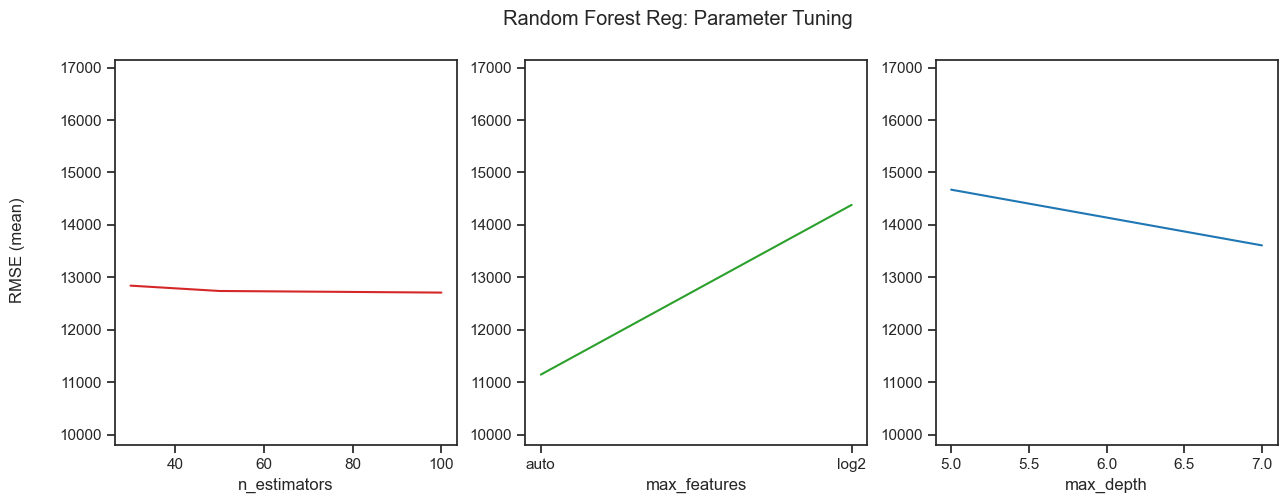

In [30]:
# extracting certain values from random forest grid search results
cv_rf_scores = np.sqrt(-(grid_search_rf.cv_results_['mean_test_score']))
cv_rf_max_depth = list(grid_search_rf.cv_results_['param_max_depth'])
cv_rf_max_features = list(grid_search_rf.cv_results_['param_max_features'])
cv_rf_n_estimators = list(grid_search_rf.cv_results_['param_n_estimators'])

# setting up a data frame for plotting
rf_gridsearch_cv_results = pd.DataFrame({'RMSE': cv_rf_scores,
                                        'max depth': cv_rf_max_depth,
                                        'max features': cv_rf_max_features,
                                        'n_estimators': cv_rf_n_estimators})
# subsetting data frame by grouping 
n_esti = pd.DataFrame(rf_gridsearch_cv_results.groupby('n_estimators')['RMSE'].mean())
max_feat = pd.DataFrame(rf_gridsearch_cv_results.groupby('max features')['RMSE'].mean())
max_depth = pd.DataFrame(rf_gridsearch_cv_results.groupby('max depth')['RMSE'].mean())


# plotting results
y1 = n_esti['RMSE']
y2 = max_feat['RMSE']
y3 = max_depth['RMSE']
x1 = list(n_esti.index)
x2 = list(max_feat.index)
x3 = list(max_depth.index)

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 5))
fig.suptitle('Random Forest Reg: Parameter Tuning')

ax1.plot(x1, y1,'tab:red') 
ax1.set_ylim([cv_rf_scores.min(), cv_rf_scores.max()])
ax2.plot(x2, y2, 'tab:green')
ax2.set_ylim([cv_rf_scores.min(), cv_rf_scores.max()])
ax3.plot(x3, y3, 'tab:blue')
ax3.set_ylim([cv_rf_scores.min(), cv_rf_scores.max()])
ax1.set(xlabel="n_estimators")
ax2.set(xlabel="max_features")
ax3.set(xlabel="max_depth")
fig.text(0.06, 0.5, 'RMSE (mean)', ha='center', va='center', rotation='vertical')


Analysing the parameter optimisation process for Random Forest regression, we can see that the numer of trees fitted (*n_estimators*) does not strongly affect averag RSME scores. However, the plot above shows that the model performs better if more features are considered in order to make the best split ($\sqrt{231}$ > $\log{231}$, where *auto* is the default setting, indication $\sqrt{n_{features}}$). The model also performs better if it is allowed to make mor splits for each fitted tree.

In [31]:
# defining final model
final_model = RF_reg

## System Evaluation (Test Set) and Conclusion
As we decided on which model and model parameters to use, the next step is to evaluate model performance on the test set.

First, this test set has to be pre-processed using the fitted pipeline from above. Afterwards, the final Random Forest model is used to predict car prices based on the test matrix. Predictive power is assessed through RSME and the $R^2$ criterion.

In [32]:
# separating labels 'price' 
Y_test = test_strat['price'].copy()
test_strat = test_strat.drop(columns = ['price'], axis = 1) # dropping price

# pipeline for data preparation
X_test = data_pipeline.transform(test_strat) # transforming the raw test data with the pre-fitted pipeline
X_test = sparse_to_df(X_test, index = test_strat.index)

Y_hat_test = final_model.predict(X_test)

test_mse = mean_squared_error(Y_test, Y_hat_test) 
test_rmse = np.sqrt(test_mse)
test_r_sq = final_model.score(X_test, Y_test)


results = pd.DataFrame({'RMSE': [test_rmse],
                       'R^2 score': [test_r_sq]})

results.style.set_table_attributes("style='display:inline'").set_caption('final model: results')

,RMSE,R^2 score
0,7691.275169,0.851570


The model performs arguably well on the test data with a lower RMSE as the mean score from the cross-validation. A coefficient of determination ($R^2$) of 0.85 also shows that the model fits well to the data. However, we have to keep in mind that model evaluation showed a large variance in model accuracy.

## Conclusion and Interpretation
Although the model performs arguably well on the test set, it is still lacking accuracy and is suffering from variance. As the RMSE measures the average difference between predicted and actual price values, a difference of almost USD 7700 is far too large for using the model in a practical real-world setting, given that most cars have a price between USD 18,000 and USD 32,000. This error can even be larger as the cross-validation results show.

Using a larger amount of data for model training would be one option to optimize the model performance. However, it did not solve the problem in this case: The average cross-validation scores constantly show large variance and average RMSE scores were even lower on less data (mean RMSE of 6407 and 5924, using 100MB and 300MB of data, respectively). Although we cannot exclude the possibility of overfitting, running the model on a larger amount of data (using 1GB on another PC) or changing model covariates did not result in significantly better performance.  

One possible explanation for both the large RMSE and the model variance could lie in the severe price outliers included in the data. These outliers cause a strong increase in RMSE and futher can be the explanation for the bad model performance in fold 4 of the cross-validation assessment, as this fold might include a high proportion of car price outliers. 

Adding more of these hyper-expensive cars to the training data could possibly enable the model to learn new patterns and predict the price of these cars better. Another approach to solve this issue could be the use of different models which handel outliers better due to the usage of weighting techniques. 